## 2RPFS Problem (Cmax objective) - Tables and Graphs

Before running this, notebook, please run notebooks 0.1 and 0.2 (in this order).

In [1]:
import pandas as pd
import numpy as np
import os, fnmatch
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
import glob
import seaborn as sns

%matplotlib inline

In [2]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

### List files in the result folder 

In [3]:
resultfolder = os.path.join(os.getcwd(), 'results', 'consolidated')
rpfs_file = os.path.join(resultfolder, '2RPFS_Cmax_all_results.csv')
det_file = os.path.join(resultfolder, 'PFSP_Cmax_deterministic_all_results.csv')
stoc_file = os.path.join(resultfolder, 'simgrasp_cmax_ying_stochgrasp_results.csv')

### Create the output folder 

In [160]:
outputfolder = os.path.join(os.getcwd(), 'results', 'consolidated')
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)
#print('Saving files on folder: ' + outputfolder)

### Process consolidated CSV result files

In [153]:
df_rpfs = pd.read_csv(rpfs_file, delimiter=';')
df_dpfs = pd.read_csv(det_file, delimiter=';')
df_rpfs.drop(columns=['executionId'], inplace=True)
df_dpfs.drop(columns=['executionId'], inplace=True)
df_stoc = pd.read_csv(stoc_file, delimiter=',')

Robust dataframe: calculating new fields

In [154]:
df_rpfs['optimal'] = df_rpfs['is_optimal'] & df_rpfs['validated'] & (df_rpfs['gap'] <= 1e-5)
df_rpfs['time_limit'] = 7200.0
df_rpfs['time'] = np.minimum(df_rpfs['time_spent'], df_rpfs['time_limit'])
df_rpfs['gap'] = df_rpfs['gap'] * 100
df_rpfs['worstcase_cost'] = df_rpfs['cmax_dp']

In [7]:
df_rpfs_wagner = df_rpfs[(df_rpfs['model'] == 'Wagner')]
df_rpfs_wilson = df_rpfs[(df_rpfs['model'] == 'Wilson')]

In [8]:
df_rpfs[['time', 'time_spent']]

,time,time_spent
0,6.34,6.34
1,0.11,0.11
2,0.08,0.08
3,0.06,0.06
4,0.06,0.06
...,...,...
15360,7200.00,11273.43
15361,7200.00,10169.19
15362,652.67,652.67
15363,6095.16,6095.16


In [147]:
df_rpfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15365 entries, 0 to 15364
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   model                  15365 non-null  object 
 1   n                      15365 non-null  int64  
 2   m                      15365 non-null  int64  
 3   alpha                  15365 non-null  int64  
 4   instance_name          15365 non-null  object 
 5   Gamma1                 15365 non-null  int64  
 6   Gamma2                 15365 non-null  int64  
 7   ub_name                15365 non-null  object 
 8   budget_Gamma           15365 non-null  object 
 9   cmax                   15365 non-null  float64
 10  permutation            15365 non-null  object 
 11  time_spent             15365 non-null  float64
 12  time_to_best_sol       15365 non-null  float64
 13  iterations             15365 non-null  int64  
 14  num_visited_solutions  15365 non-null  int64  
 15  nu

### Analyzing the stochastic solutions dataframe (SimGRASP) 

In [12]:
df_stoc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   filename              7500 non-null   object 
 1   simgrasp_instance     7500 non-null   object 
 2   n                     7500 non-null   int64  
 3   m                     7500 non-null   int64  
 4   nehtdist              7500 non-null   object 
 5   beta1                 7500 non-null   float64
 6   beta2                 7500 non-null   float64
 7   seed                  7500 non-null   int64  
 8   rob_pfsp_instance     7500 non-null   object 
 9   alpha                 7500 non-null   int64  
 10  seq                   7500 non-null   int64  
 11  stochsol_sol_id       7500 non-null   int64  
 12  stochsol_cost         7500 non-null   float64
 13  stochsol_exp_cost     7500 non-null   float64
 14  stochsol_time         7500 non-null   float64
 15  stochsol_permutation 

In [13]:
def split_budget_gamma_column(df):
    # new data frame with split value columns 
    new = df["budget_Gamma"].str.split(" ", n = 1, expand = True) 
    # making separate first name column from new data frame 
    df["Gamma1"]= new[0] 
    # making separate last name column from new data frame 
    df["Gamma2"]= new[1] 
    # convert Gamma columns to numeric
    df["Gamma1"] = pd.to_numeric(df["Gamma1"], errors='coerce')
    df["Gamma2"] = pd.to_numeric(df["Gamma2"], errors='coerce')
    return df

In [14]:
df_stoc['instance_name'] = df_stoc['rob_pfsp_instance']

budget_list = []
for g1 in [20, 40, 60, 80, 100]:
    for g2 in [20, 40, 60, 80, 100]:
        budget_list.append('{} {}'.format(g1, g2))
df_ssgrasp = pd.melt(df_stoc, id_vars=['n', 'm', 'alpha', 'instance_name', 'stochsol_exp_cost', 'stochsol_time'], 
                     value_vars=budget_list, var_name='budget_Gamma', value_name='worstcase_cost')
df_ssgrasp = split_budget_gamma_column(df_ssgrasp)
df_ssgrasp

,n,m,alpha,instance_name,stochsol_exp_cost,stochsol_time,budget_Gamma,worstcase_cost,Gamma1,Gamma2
0,10,2,10,RB0101001.txt,276.373281,0.021687,20 20,285.1,20,20
1,10,2,10,RB0101001.txt,276.324248,0.387044,20 20,285.1,20,20
2,10,2,10,RB0101001.txt,276.062506,0.388751,20 20,285.1,20,20
3,10,2,10,RB0101001.txt,275.256296,0.173538,20 20,285.1,20,20
4,10,2,10,RB0101001.txt,275.880396,0.128225,20 20,285.1,20,20
...,...,...,...,...,...,...,...,...,...,...
187495,200,2,50,RB2005010.txt,6125.277577,11.302099,100 100,9192.0,100,100
187496,200,2,50,RB2005010.txt,6139.407227,10.835846,100 100,9192.0,100,100
187497,200,2,50,RB2005010.txt,6132.221400,1.408566,100 100,9192.0,100,100
187498,200,2,50,RB2005010.txt,6127.664485,0.948341,100 100,9192.0,100,100


Notice we have 25 executions for each instance file (and respective alpha parameter). For result comparison, we will need one worstcase cost per instance and budget_Gamma. For now, we will group by instance file in order to obtain the smallest worstcase cost found after 25 SimGRASP executions:

In [46]:
#df_ssgrasp_min_worstcost = df_ssgrasp.groupby(['n', 'm', 'alpha', 'instance_name', 'stochsol_exp_cost', 'stochsol_time', 
#                                               'budget_Gamma', 'Gamma1', 'Gamma2']).min()
ssgrasp_columns = ['n', 'm', 'alpha', 'instance_name', 'budget_Gamma', 'Gamma1', 'Gamma2']
df_ssgrasp_min_worstcost = df_ssgrasp[df_ssgrasp['worstcase_cost'] == df_ssgrasp.groupby(ssgrasp_columns)['worstcase_cost']
                                                                                  .transform('min')]
df_ssgrasp_min_worstcost = df_ssgrasp_min_worstcost.sort_values(ssgrasp_columns).drop_duplicates(ssgrasp_columns)
df_ssgrasp_max_worstcost = df_ssgrasp[df_ssgrasp['worstcase_cost'] == df_ssgrasp.groupby(ssgrasp_columns)['worstcase_cost']
                                                                                  .transform('max')]
df_ssgrasp_max_worstcost = df_ssgrasp_max_worstcost.sort_values(ssgrasp_columns).drop_duplicates(ssgrasp_columns)

display(df_ssgrasp_min_worstcost.tail(4))
display(df_ssgrasp_max_worstcost.tail(4))

,n,m,alpha,instance_name,stochsol_exp_cost,stochsol_time,budget_Gamma,worstcase_cost,Gamma1,Gamma2
119990,200,2,50,RB2005010.txt,6128.390342,1.376442,80 20,8896.5,80,20
127484,200,2,50,RB2005010.txt,6126.635774,2.891115,80 40,8917.0,80,40
134984,200,2,50,RB2005010.txt,6126.635774,2.891115,80 60,8929.5,80,60
142483,200,2,50,RB2005010.txt,6130.197784,6.675256,80 80,8952.0,80,80


,n,m,alpha,instance_name,stochsol_exp_cost,stochsol_time,budget_Gamma,worstcase_cost,Gamma1,Gamma2
119987,200,2,50,RB2005010.txt,6139.688176,8.435012,80 20,9139.5,80,20
127476,200,2,50,RB2005010.txt,6137.103175,2.966949,80 40,9174.0,80,40
134976,200,2,50,RB2005010.txt,6137.103175,2.966949,80 60,9174.0,80,60
142476,200,2,50,RB2005010.txt,6137.103175,2.966949,80 80,9174.0,80,80


In [43]:
df_ssgrasp_min_worstcost[(df_ssgrasp_min_worstcost['instance_name'] == 'RB0101001.txt')]

,n,m,alpha,instance_name,stochsol_exp_cost,stochsol_time,budget_Gamma,worstcase_cost,Gamma1,Gamma2
180000,10,2,10,RB0101001.txt,276.373281,0.021687,100 100,303.6,100,100
150000,10,2,10,RB0101001.txt,276.373281,0.021687,100 20,303.6,100,20
157500,10,2,10,RB0101001.txt,276.373281,0.021687,100 40,303.6,100,40
165000,10,2,10,RB0101001.txt,276.373281,0.021687,100 60,303.6,100,60
172500,10,2,10,RB0101001.txt,276.373281,0.021687,100 80,303.6,100,80
30015,10,2,10,RB0101001.txt,275.787812,0.404058,20 100,285.1,20,100
0,10,2,10,RB0101001.txt,276.373281,0.021687,20 20,285.1,20,20
7503,10,2,10,RB0101001.txt,275.256296,0.173538,20 40,285.1,20,40
15003,10,2,10,RB0101001.txt,275.256296,0.173538,20 60,285.1,20,60
22503,10,2,10,RB0101001.txt,275.256296,0.173538,20 80,285.1,20,80


### Robust dataframe self-join 

Now, lets join the `rpfs` dataframe with itself (inner join). This will be useful to compare Wilson and Wagner models.

In [10]:
join_columns = ['n', 'm', 'alpha', 'instance_name', 'Gamma1', 'Gamma2']
df_rob_self = pd.merge(df_rpfs, df_rpfs, how='inner', on=join_columns)
df_rob_self = df_rob_self[(df_rob_self['model_x'] != df_rob_self['model_y'])]

In [11]:
df_rob_self

,model_x,n,m,alpha,instance_name,Gamma1,Gamma2,ub_name_x,budget_Gamma_x,cmax_x,...,is_optimal_y,validated_y,gap_y,lb_y,cost_y,cmax_dp_y,seq_y,time_limit_y,time_y,worstcase_cost_y
1,Wagner,10,2,10,RB0101001.txt,20,20,mip_separation,20 20,285.1,...,True,True,-1.993806e-14,285.1,285.1,285.1,1,7200.0,5.48,285.1
2,Wilson,10,2,10,RB0101001.txt,20,20,mip_separation,20 20,285.1,...,True,True,0.000000e+00,285.1,285.1,285.1,1,7200.0,6.34,285.1
5,Wagner,10,2,10,RB0101001.txt,20,40,mip_separation,20 40,285.1,...,True,True,0.000000e+00,285.1,285.1,285.1,1,7200.0,0.08,285.1
6,Wilson,10,2,10,RB0101001.txt,20,40,mip_separation,20 40,285.1,...,True,True,-1.993806e-14,285.1,285.1,285.1,1,7200.0,0.11,285.1
9,Wagner,10,2,10,RB0101001.txt,20,60,mip_separation,20 60,285.1,...,True,True,0.000000e+00,285.1,285.1,285.1,1,7200.0,0.08,285.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31815,Wilson,200,2,50,RB2005010.txt,100,60,mip_separation,100 60,9192.0,...,True,True,0.000000e+00,9192.0,9192.0,9192.0,10,7200.0,306.81,9192.0
31818,Wagner,200,2,50,RB2005010.txt,100,80,mip_separation,100 80,9192.0,...,True,True,0.000000e+00,9192.0,9192.0,9192.0,10,7200.0,6095.16,9192.0
31819,Wilson,200,2,50,RB2005010.txt,100,80,mip_separation,100 80,9192.0,...,True,True,0.000000e+00,9192.0,9192.0,9192.0,10,7200.0,129.10,9192.0
31822,Wagner,200,2,50,RB2005010.txt,100,100,mip_separation,100 100,9192.0,...,True,True,0.000000e+00,9192.0,9192.0,9192.0,10,7200.0,196.20,9192.0


# Tables

## Table 1. Average worst-case Cmax Wagner 

In [ ]:
table = pd.pivot_table(df_rpfs_wagner, values='cmax_dp', index=['Gamma1', 'Gamma2'], columns=['alpha', 'n'], aggfunc='mean', fill_value=0)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(table)

## Table 2. Average run time Wagner robust model

In [ ]:
table = pd.pivot_table(df_rpfs_wagner, values='time', index=['Gamma1', 'Gamma2'], columns=['alpha', 'n'], aggfunc='mean', fill_value=0)
table = np.round(table, 2)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(table)

## Table 3. Performance all instances 

In [ ]:
df_rob_self['x_wins_y_time'] = (df_rob_self['time_x'] < df_rob_self['time_y']).astype(int)

In [ ]:
table = pd.pivot_table(df_rob_self, columns=['n', 'model_x'], values=['time_x', 'gap_x', 'iterations_x', 'x_wins_y_time'],
                       aggfunc={'time_x' : ['mean', 'std'], 'gap_x' : 'mean', 'iterations_x' : ['mean', 'std'],
                               'x_wins_y_time' : ['sum']})  # , margins=True, fill_value=0)
table['perc_x_wins_y_time'] = table['x_wins_y_time'] * 100 / 1250
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(table)

In [ ]:
df_grouped = df.groupby(['alpha', 'n', 'm', 'budget_Gamma']).agg({'executionId' : ['count']}).reset_index()
df_grouped.columns = [ ' '.join(str(i) for i in col) for col in df_grouped.columns]
#df_grouped.reset_index(inplace=True)
df_grouped

In [ ]:
table = pd.pivot_table(df, values='executionId', index=['alpha', 'n'], columns=['Gamma1', 'Gamma2'], aggfunc='count', fill_value=0)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(table)

# Graphs

### Build a dataframe joining the `df_rpfs` and `df_dpfs`

In [23]:
join_columns = ['n', 'm', 'alpha', 'instance_name', 'Gamma1', 'Gamma2']
df_det_d0 = df_dpfs[(df_dpfs['perc_deviation_p_bar'] == 0)]
df_det_d100 = df_dpfs[(df_dpfs['perc_deviation_p_bar'] == 100)]
# join robust and deterministic dfs
df_join_rob_det = pd.merge(df_rpfs, df_det_d0, how='inner', on=join_columns, suffixes=('_rob', '_d0'))
df_join_rob_det = pd.merge(df_join_rob_det, df_det_d100, how='inner', on=join_columns, suffixes=('_d0', '_d100'))

### Build a dataframe concatenating `df_rpfs` and `df_dpfs`

In [61]:
def plot_worstcase_comparison(instance_name, df_dict):
    concat_columns = ['instance_name', 'Gamma1', 'Gamma2', 'budget_Gamma', 'worstcase_cost']
    for key, df_i in df_dict.items():
        df_i = df_i[concat_columns]
        df_i['Method'] = key
        df_dict[key] = df_i
    df = pd.concat(df_dict.values())
    df = df[(df['instance_name'] == instance_name)]
    # https://www.drawingfromdata.com/setting-figure-size-using-seaborn-and-matplotlib
    #fig, ax = plt.subplots()
    # the size of A4 paper
    #fig.set_size_inches(11.7, 8.27)
    marker = ['*', '+', 'o', 'x', '^', '8', 's', 'p', 'D', 'V']
    markers = [marker[i] for i in range(len(df["Method"].unique()))]
    linestyle = ['--', '-.', ':', 'dashed', 'dashdot', 'dotted', 'solid', '-', ' ', '']
    linestyles = [linestyle[i] for i in range(len(df["Method"].unique()))]
    a4_dims = (11.7, 8.27)
    plt.figure(figsize=a4_dims)
    sns.catplot(x="budget_Gamma", y="worstcase_cost",  markers=markers, linestyles=linestyles,
                 hue="Method", kind="point", style="Method", 
                 data=df,
                 height=5, # make the plot 5 units high
                 aspect=3) # height should be three times width
    plt.show()
    plt.savefig(os.path.join(outputfolder, '{}.svg'.format(instance_name)))

### Worstcase cost : Small Uncertainty Range Instance - Example 

Alpha = 10% and n = 50

TODO Comparar também com o RobPFSP - Minimax Regret

<Figure size 842.4x595.44 with 0 Axes>

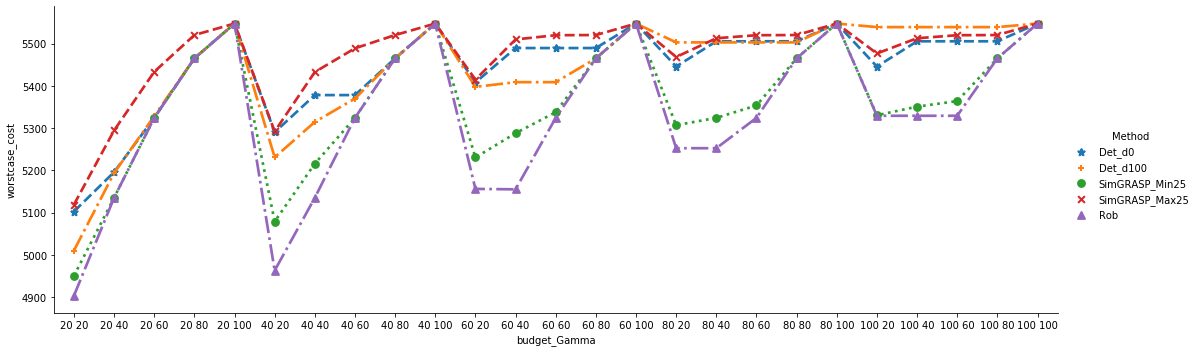

<Figure size 432x288 with 0 Axes>

In [105]:
#filename = 'RB0501003.txt'  # Small Uncertainty range
filename = 'RB0201009.txt'  # Small Uncertainty range
filename = 'RB1001007.txt'  # Small Uncertainty range
filename = 'RB1501006.txt'  # Small Uncertainty range
filename = 'RB1502008.txt' # 'RB1502001.txt', 'RB1502006.txt', 'RB1502009.txt', 'RB1502010.txt'
# filename = 'RB0201007.txt'
#filename = 'RB0105010.txt'  # Large Uncertainty range
plot_worstcase_comparison(filename, {'Det_d0' : df_det_d0, 'Det_d100' : df_det_d100, 
                                     'SimGRASP_Min25' : df_ssgrasp_min_worstcost, 'SimGRASP_Max25' : df_ssgrasp_max_worstcost,
                                     'Rob' : df_rpfs_wagner})

### Worstcase cost : Large Uncertainty Range Instance - Example 

Alpha = 50% and n = 10

<Figure size 842.4x595.44 with 0 Axes>

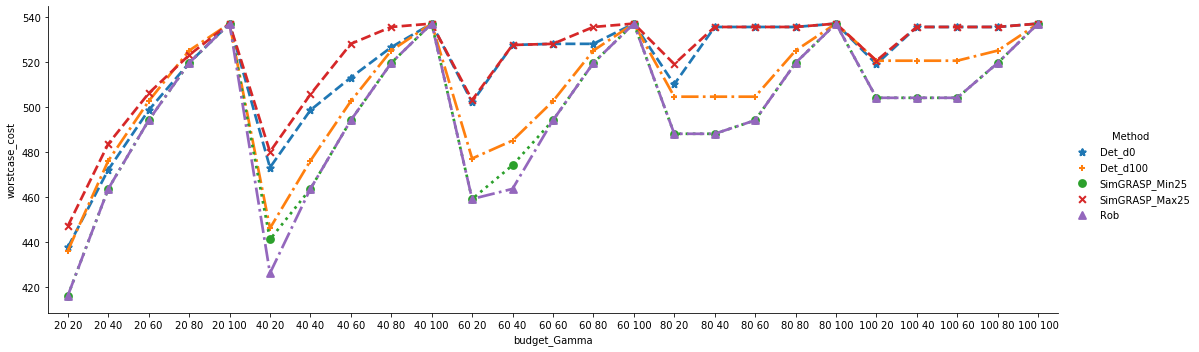

<Figure size 432x288 with 0 Axes>

In [146]:
filename = 'RB0105010.txt'  # Large Uncertainty range: 'RB0505006.txt', 'RB0505003.txt', 'RB1005003.txt', 'RB1005006.txt', 'RB1005008.txt', 'RB1005009.txt'
#filename = 'RB1505001.txt'  # 'RB0205001.txt', 'RB0205003.txt', 'RB0205008.txt', 'RB0205009.txt', 'RB0505010.txt', 'RB0505009.txt'
# 'RB1505008.txt', 'RB1505007.txt', 'RB1505006.txt', 'RB1505004.txt', 'RB1505001.txt'
plot_worstcase_comparison(filename, {'Det_d0' : df_det_d0, 'Det_d100' : df_det_d100, 
                                     'SimGRASP_Min25' : df_ssgrasp_min_worstcost, 'SimGRASP_Max25' : df_ssgrasp_max_worstcost,
                                     'Rob' : df_rpfs_wagner})

In [158]:
def get_instance_solution_info(df_rpfs, instance_name):
    return df_rpfs[(df_rpfs['instance_name'] == instance_name)][['Gamma1', 'Gamma2', 'is_optimal', 
                                                                   'validated', 'gap', 'time', 'optimal']]

In [159]:
get_instance_solution_info(df_rpfs, 'RB1505002.txt')

,Gamma1,Gamma2,is_optimal,validated,gap,time,optimal
6025,20,20,True,True,3.750878,7200.00,False
6026,20,40,True,True,1.468189,7200.00,False
6027,20,60,True,True,0.083459,7200.00,False
6028,20,80,True,True,0.047578,7200.00,False
6029,20,100,True,True,0.000000,36.33,True
6030,40,20,True,True,0.091233,7200.00,False
6031,40,40,True,True,0.090114,7200.00,False
6032,40,60,True,True,0.066661,7200.00,False
6033,40,80,True,True,0.000000,69.21,True
6034,40,100,True,True,0.000000,15.57,True


### Export the dataset to CSV file 

In [ ]:
%%time

print('Saving file on folder: ' + rootfolder)
fname = os.path.join(rootfolder, '2RPFS_Cmax_all_results.csv')
df.to_csv(fname, sep=';')
print('Saved: ' + fname)